## The goal of this notebook is to further improve on baseline classification performance for the diagnosis of Crohn's Disease using an MLP classifier

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.patches as mpatches


from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, make_scorer
from sklearn.utils import resample
from tqdm.notebook import tqdm
from statsmodels.stats.weightstats import ztest as ztest

import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def to_dataframe(mat):
    X = mat['XTIC']
    y = mat['CLASS']
    df = pd.DataFrame(X)
    df.index = [x for x in [x for x in mat['SAM'] for x in x] for x in x]
    
    return df, y

def print_counts(y):
    unlisted = [x for x in y for x in x]
    control_count = unlisted.count(1)
    disease_count = unlisted.count(2)
    print(f'n controls: {control_count}\nn disease: {disease_count}')

def pca_(X, n):
    sscaler = StandardScaler()
    sscaler.fit(X)
    scaled_X = sscaler.transform(X)
    
    pca = PCA(n_components = n)
    pca.fit(scaled_X)
    pca_results = pca.transform(scaled_X)
    print(f'pca shape {np.shape(pca_results)}')
    
    return pca, pca_results

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(n, input_shape=(n,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
def deeper_larger():
    # create model
    model = Sequential()
    model.add(Dense(n, input_shape=(n,), activation='relu'))
    model.add(Dense(n//2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def evaluate_pipeline(model_, scaler):
    estimators = []
    estimators.append(('standardize', scaler()))
    estimators.append(('mlp', KerasClassifier(model=model_(), epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'auc': 'roc_auc'
    }
    
    cv_results = cross_validate(estimator=pipeline, X=X, y=encoded_Y, cv=kfold, scoring=scoring)
    
    for key in list(cv_results.keys())[2:]:
        print(f"mean_{key[5:]}: {round(cv_results[key].mean()*100, 2)}% ({round(cv_results[key].std()*100, 2)})%")
        
    return cv_results

In [5]:
def confidence_interval(alpha, stats):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print(f'{alpha*100} confidence interval {round(lower*100, 2)} and {round(upper*100, 2)}')
    
    return lower, upper

In [6]:
def evaluate_pipeline(model_, scaler):
    estimators = []
    estimators.append(('standardize', scaler()))
    estimators.append(('mlp', KerasClassifier(model=model_(), epochs=100, batch_size=5, verbose=0)))
    pipeline = Pipeline(estimators)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'auc': 'roc_auc'
    }
    
    cv_results = cross_validate(estimator=pipeline, X=X, y=encoded_Y, cv=kfold, scoring=scoring)
    df_results = pd.DataFrame(cv_results).iloc[:,2:]
    x_pos = df_results.index
    y = df_results.apply(lambda x: round(np.mean(x)*100, 2))
    stds = df_results.apply(lambda x: round(np.std(x)*100, 2))
    
    for col in y.index:
        print(f"mean_{col}: {y[col]}% ({stds[col]})%")
    
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.bar(range(4), y, yerr=stds, align='center', color='skyblue', ecolor='orange')
    ax.set_xticks(range(4), [f"mean_{name}"for name in y.index])
    ax.yaxis.grid(True)
    plt.tight_layout()
    
    return cv_results

In [7]:
def bootstrap_mlp(X, y, model_, n_iterations):
    data = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1)
    # run bootstrap
    stats = []

    for i in tqdm(range(n_iterations)):
        # prepare train and test sets
        train = resample(data, replace = True, n_samples=len(y))
        test = data[~data.index.isin(train.index)]
        # fit model
        estimators = []
        estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', KerasClassifier(model=model_(), epochs=100, batch_size=5, verbose=0)))
        pipeline = Pipeline(estimators)
        pipeline.fit(train.iloc[:, :-1],train.iloc[:,-1])
        
        # evaluate model
        predictions = pipeline.predict(test.iloc[:,:-1])
        score = accuracy_score(test.iloc[:,-1], predictions)
        stats.append(score)
    
    lower_CI, upper_CI = confidence_interval(0.95, stats)
    
    return stats, lower_CI, upper_CI

In [8]:
def bootstrap_permuted(X, y, model_, n_iterations):
    stats = []

    for i in tqdm(range(n_iterations)):
        data = pd.concat([pd.DataFrame(X), pd.DataFrame(np.random.permutation(y))], axis = 1)
        # prepare train and test sets
        train = resample(data, replace = True, n_samples=len(y))
        test = data[~data.index.isin(train.index)]
        # fit model
        estimators = []
        estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', KerasClassifier(model=model_(), epochs=100, batch_size=5, verbose=0)))
        pipeline = Pipeline(estimators)
        pipeline.fit(train.iloc[:, :-1],train.iloc[:,-1])
        
        # evaluate model
        predictions = pipeline.predict(test.iloc[:,:-1])
        score = accuracy_score(test.iloc[:,-1], predictions)
        stats.append(score)
    
    lower_CI, upper_CI = confidence_interval(0.95, stats)
    
    return stats, lower_CI, upper_CI

### Load and preprocess data

In [9]:
df_blood, y_blood = to_dataframe(loadmat('datasets/BWG_BL_CDvCTRL.mat'))
df_breath, y_breath = to_dataframe(loadmat('datasets/BWG_BR_CDvCTRL.mat'))
df_urine, y_urine = to_dataframe(loadmat('datasets/BWG_UR_CDvCTRL.mat'))
df_faecal, y_faecal = to_dataframe(loadmat('datasets/BWG_FA_CDvCTRL.mat'))

In [10]:
sample_types = ['blood', 'breath', 'urine', 'faecal']

for y, sample_type in zip([y_blood, y_breath, y_urine, y_faecal],sample_types):
    print(sample_type)
    print_counts(y)

blood
n controls: 18
n disease: 14
breath
n controls: 19
n disease: 16
urine
n controls: 14
n disease: 8
faecal
n controls: 12
n disease: 11


### Evaluate MLP classifier with cross validation for optimal hyperparams

In [11]:
n = 6

In [12]:
tfpca, tf_fa_X = pca_(df_faecal, n)

pca shape (23, 6)


In [13]:
X = tf_fa_X
Y = np.ravel(y_faecal)
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

Metal device set to: Apple M1 Pro


2022-11-10 14:37:07.809189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-10 14:37:07.809331: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Assets written to: ram:///var/folders/53/44bw80w567q39zrt8t3jn72c0000gn/T/tmp_t9e2xrn/assets


2022-11-10 14:37:08.350084: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-10 14:37:08.506287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram:///var/folders/53/44bw80w567q39zrt8t3jn72c0000gn/T/tmpejg71qqq/assets


2022-11-10 14:37:10.729477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:11.136552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram:///var/folders/53/44bw80w567q39zrt8t3jn72c0000gn/T/tmpoj6tkatq/assets


2022-11-10 14:37:13.266011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:13.707074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:15.784612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram:///var/folders/53/44bw80w567q39zrt8t3jn72c0000gn/T/tmpw68byxau/assets


2022-11-10 14:37:16.286269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:18.412201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram:///var/folders/53/44bw80w567q39zrt8t3jn72c0000gn/T/tmpk2tf_dgr/assets


2022-11-10 14:37:18.876311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


mean_test_accuracy: 92.0% (9.8)%
mean_test_sensitivity: 100.0% (0.0)%
mean_test_specificity: 83.33% (21.08)%
mean_test_auc: 90.0% (20.0)%


2022-11-10 14:37:20.983847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


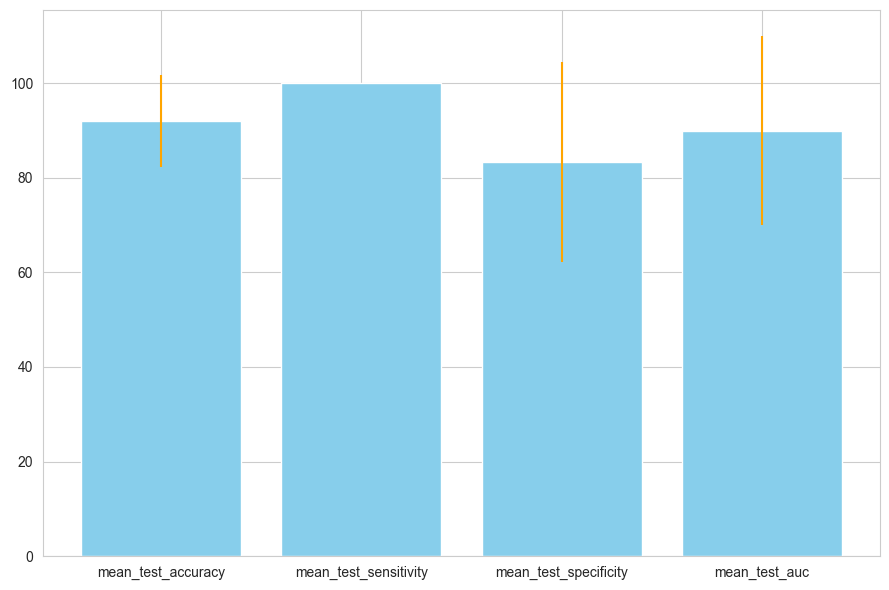

In [14]:
metrics_d = evaluate_pipeline(model_=deeper_larger, scaler=StandardScaler)

### Running bootstrap sampling to define 95% confidence interval of classification accurracy given a small dataset


In [15]:
acc, lower_CI, upper_CI = bootstrap_mlp(X, encoded_Y, deeper_larger, 150)

  0%|          | 0/150 [00:00<?, ?it/s]

2022-11-10 14:37:21.314947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2022-11-10 14:37:23.941021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:24.129824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:26.773514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:26.996872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:29.804038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:30.009830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:37:32.764497: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:38:42.889122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:43.087903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:45.825202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:46.007775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:48.738925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:48.913529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:38:51.714481: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:40:05.034217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:05.226309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:08.024501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:08.215855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:10.934462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:11.124147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:40:13.866520: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:41:30.280553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:30.461373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:33.365377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:33.545675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:36.401346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:36.591843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:41:39.696645: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:42:52.397518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:42:52.616656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:42:55.416290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:42:55.607243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:42:58.361391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:42:58.545276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:43:01.273465: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:44:25.314507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:28.824795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:29.039103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:32.575939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:32.796612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:36.350077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:44:36.578427: I tensorflow/core/grappler/optimizers/cust

95.0 confidence interval 25.0 and 100.0


2022-11-10 14:45:22.242403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Generating permuted dataset and calculating classification accuracy

In [16]:
perm_acc, lower_CI_perm, upper_CI_perm = bootstrap_permuted(X,encoded_Y, deeper_larger, 150)

  0%|          | 0/150 [00:00<?, ?it/s]

2022-11-10 14:45:22.476350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:26.015763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:26.254378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:30.072017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:30.313135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:33.978037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:45:34.223393: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:47:05.313956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:05.532144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:09.060534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:09.296009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:12.842291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:13.063987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:47:16.525833: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:48:43.522572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:47.023810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:47.262126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:50.769431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:51.000080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:54.558795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:48:54.777151: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:50:25.900746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:26.158265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:29.767274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:30.007397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:33.607153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:33.862659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:50:37.414633: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:52:08.681513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:12.352864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:12.596381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:16.226064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:16.465291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:20.182631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:52:20.432935: I tensorflow/core/grappler/optimizers/cust

2022-11-10 14:53:55.157313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:53:55.412688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:53:59.163093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:53:59.402123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:54:03.075812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:54:03.327529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-10 14:54:07.019780: I tensorflow/core/grappler/optimizers/cust

95.0 confidence interval 13.79 and 79.96


2022-11-10 14:55:03.600195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### 2 sample z test to evaluate significance of difference between true classification results and permutation test results. Highly significant value achieved suggests that the sample means are not equal.

In [17]:
np.mean(acc)

0.7151143486143486

In [18]:
np.mean(perm_acc)

0.4590791245791246

In [19]:
ztest(acc, perm_acc, value=0) 

(12.214157927006546, 2.611918045965571e-34)